<a href="https://colab.research.google.com/github/kartk/ML/blob/main/Decision_Trees_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pptree

  Created wheel for pptree: filename=pptree-3.1-cp36-none-any.whl size=4632 sha256=5209ca0eb13dc681afa984a3fa7ea6e5cc7fbd82e4a4a1fa0a4864bf5671e560
  Stored in directory: /root/.cache/pip/wheels/ff/bf/ee/8b67eb5467e12cf1bd0125df70d8c9f076bd7ea225b5bcea9b
Successfully built pptree


In [21]:
import numpy as np
from typing import List, Tuple
from ppbtree import print_tree
import matplotlib.pyplot as plt
from collections import Counter 
import warnings
warnings.filterwarnings('ignore')

In [140]:
class Node:
  def __init__(self, data):
    self.left = None
    self.right = None
    self.data = data
  def pretty_print(self):
      print_tree(self,nameattr="data")


class DecisionTree:
  # def __init__(self, k:int, m:int )-> None:
  #   self.data = DecisionTree.datagenerator(k,m)
  #   self.tree = None
  #   self.k = k
  #   self.m = m
  
  def __init__(self,data:np.array = None,k:int=None, m:int=None, d:int = None, s:int = None )-> None:
    assert ((data is None) and ( m is not None)) or ((data is not None) and ( m is None)), "Both m(size) and data can't be empty" 
    assert ((d is None) and (s is not None)) or ((d is not None) and (s is None)) or ((d is None) and (s is None)), "Give either d(depth size) or s(sample size), not both!"
    self.k = data.shape[1] if data is not None else k
    self.m = data.shape[0] if data is not None else m
    self.data = data if data is not None else DecisionTree.datagenerator2(m) if k is None else DecisionTree.datagenerator(k, m)    
    self.d = d
    self.s = s
    self.tree = None
    self.nodes = Counter()
  
  @classmethod
  def datagenerator(self, k:int, m:int)->List[List[int]]:
    """
    Input:
      k: number of features
      m: number of data points
    Returns:
      Numpy array of size (m,k)
    """
    # data = []
    w_den = sum([np.power(0.9, i) for i in range(2, k+1)])
    # for i in range(m):
    #   X = [np.random.choice([1,0], p=[0.5, 0.5])]
    #   for j in range(1,k):
    #     X.append(np.random.choice([X[j-1], 1-X[j-1]], p = [0.75, 0.25]))
    #   X.append(X[0] if (sum([ np.power(0.9, j)/w_den * X_j for j, X_j in enumerate(X[1:])]) >= 0.5) else (1 - X[0]))
    #   data.append(X)
    # return np.array(data)

    data = [[0 for _ in range(k+1)] for _ in range(m)]
    for i in range(m):
      for j in range(k):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        # if (j >= 15) and (j<21):
        #   data[i][j] = 0 if np.random.random() <= 0.5 else 1
      data[i][k] = data[i][0] if (sum([ np.power(0.9, j+2)/w_den * X_j for j, X_j in enumerate(data[i][1:])]) >= 0.5) else (1 - data[i][0])
    return np.array(data)

  @classmethod
  def datagenerator2(self, m:int)->np.array:
    """
    Input:
      m: number of data points
    Returns:
      Numpy array of size (m,k)
    """
    # data = []
    # for i in range(m):
    #   row = [np.random.choice([1,0], p=[0.5, 0.5])]
    #   for j in range(1,15):
    #     row.append(np.random.choice([row[j-1], 1-row[j-1]], p = [0.75, 0.25]))
    #   for j in range(15,21):
    #     row.append(np.random.choice([1,0], p=[0.5, 0.5]))
      
    #   row.append(np.bincount(row[8:15]).argmax() if row[0] else np.bincount(row[1:8]).argmax())
    #   data.append(row)
    # return np.array(data)

    data = [[0 for _ in range(22)] for _ in range(m)]
    for i in range(m):
      for j in range(21):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1) and (j<=14):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        if (j >= 15) and (j<21):
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
      data[i][21] = np.bincount(data[i][8:15]).argmax() if data[i][0] else np.bincount(data[i][1:8]).argmax()
    return np.array(data)


  def regenerate_data(self, k=None, m=None)->None:
    self.data = DecisionTree.datagenerator(k if k else self.k , m if m else self.m) \
    if k is not None else DecisionTree.datagenerator2(m if m is not None else self.m)

  def entropy(self, vector:np.array)->np.array:
    P_0 = (vector == 0).sum(0) / len(vector)
    P_1 = (vector == 1).sum(0) / len(vector)
    H_Y = - P_0 * np.log2(P_0) - P_1 * np.log2(P_1)
    return H_Y

  def entropy_fit(self, data, depth=None):
    X, Y = data[:,:-1], data[:,-1]
    if (
        (Y == 0).sum(0) == len(Y) or (Y == 1).sum(0) == len(Y) or 
        (depth and self. d is not None and (depth > self.d)) or 
        (self.s is not None and (len(Y) <= self.s))
      ):
      # Exit Condition for pruning by sample
      if self.s and (len(Y) <= self.s):
        b= np.bincount(data[:,-1])
        max_values = [i for i, x in enumerate(b) if x == max(b)]
        if len(max_values) == 1:
          return Node(f"Y={max_values[0]}")
        else :
          if np.random.random()>0.5:
            return Node(f"Y={max_values[1]}")
          return Node(f"Y={max_values[0]}")
      # Exit Condition for pruning by depth
      if depth and self. d and (depth > self.d):
        return Node(f"Y={np.bincount(data[:,-1]).argmax()}")
      # Exit condition when all Y values are same
      return Node("Y=0") if (Y == 0).sum(0) == len(Y) else Node("Y=1")
    # Calculating H(Y)
    H_Y = self.entropy(Y)

    # # Calculating H(Y|X)
    cond_X_Y = []
    for i in range(X.shape[1]):
      P_X_0 = (X[:,i] == 0).sum(0) / len(X[:,i])
      P_X_1 = (X[:,i] == 1).sum(0) / len(X[:,i])
      H_Y_X_0 = max(0, self.entropy(Y[np.where(X[:,i]==0)]))
      H_Y_X_1 = max(0, self.entropy(Y[np.where(X[:,i]==1)]))
      cond_X_Y.append(P_X_0 * H_Y_X_0 + P_X_1 * H_Y_X_1)
    IG = H_Y - cond_X_Y
    max_IG = np.argmax(IG)
    self.nodes[max_IG] += 1
    node = Node(max_IG)
    node.left = self.entropy_fit(data[np.where(data[:,max_IG] == 0)],
                                 depth+1 if depth!=None else None)
    node.right = self.entropy_fit(data[np.where(data[:,max_IG] == 1)], 
                                  depth+1 if depth!=None else None)
    return node

  # def fit(self, data):
  #   X, Y = data[:,:-1], data[:,-1]
  #   if ((Y == 0).sum(0) == len(Y) or (Y == 1).sum(0) == len(Y)):
  #     return Node("Y=0") if (Y == 0).sum(0) == len(Y) else Node("Y=1")
  #   # Calculating H(Y)
  #   H_Y = self.entropy(Y)
  #   # # Calculating H(Y|X)
  #   cond_X_Y = []
  #   for i in range(X.shape[1]):
  #     P_X_0 = (X[:,i] == 0).sum(0) / len(X[:,i])
  #     P_X_1 = (X[:,i] == 1).sum(0) / len(X[:,i])
  #     H_Y_X_0 = max(0, self.entropy(Y[np.where(X[:,i]==0)]))
  #     H_Y_X_1 = max(0, self.entropy(Y[np.where(X[:,i]==1)]))
  #     cond_X_Y.append(P_X_0 * H_Y_X_0 + P_X_1 * H_Y_X_1)
  #   IG = H_Y - cond_X_Y
  #   max_IG = np.argmax(IG)
  #   node = Node(max_IG)
  #   node.left = self.fit(data[np.where(data[:,max_IG] == 0)])
  #   node.right = self.fit(data[np.where(data[:,max_IG] == 1)])
  #   return node
  def train(self, method="entropy"):
    if method == "entropy":
      self.tree=self.entropy_fit(self.data, 0)
    elif method == "gini":
      self.tree=self.gini_fit(self.data)
  
  def get_y(self, vector, node):
    if type(node.data) == str :
      return int(node.data[-1])
    if vector[node.data] == 0:
      return self.get_y(vector, node.left)
    else:
      return self.get_y(vector, node.right)


  def predict(self, data):
    assert self.tree is not None, "Model not trained yet!! Run train() before predict"
    correct_count = 0
    y = []
    for i in data:
      y.append(self.get_y(i, self.tree))
    return y
  
  def error(self, data=None):
    d = data if data is not None else self.data
    y_hat = self.predict(d[:,:-1])
    y = d[:, -1]
    return 1 - (y_hat == y).sum(0) / len(y)
  
  def estimate_distribution_error(self,m:int=None, N:int=100):
    error = 0
    for i in range(N):
      self.regenerate_data(k=self.k, m=m)
      error += self.error()
    return error / N

  def gini_fit(self, data):
    if (((data[:,-1]==0).sum(0) == len(data[:,-1])) or ((data[:,-1]==1).sum(0) == len(data[:,-1])) ):
      return Node("Y=0") if (data[:,-1] == 0).sum(0) == len(data[:,-1]) else Node("Y=1")
    gini = []
    for c in range(data.shape[1] - 1):
      N = len(data[:,c])
      c_0 = data[np.where(data[:,c] == 0)]
      c_1 = data[np.where(data[:,c] == 1)]
      G_c_0 = 1 - ((len(c_0[np.where(c_0[:,-1] == 0)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0) - ((len(c_0[np.where(c_0[:,-1] == 1)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0)
      G_c_1 = 1 - ((len(c_1[np.where(c_1[:,-1] == 0)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0) - ((len(c_1[np.where(c_1[:,-1] == 1)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0)
      gini.append(c_0.shape[0] / N * G_c_0 + c_1.shape[0] / N * G_c_1)
    gini = np.array(gini)
    split_var = gini.argmin()
    node = Node(split_var)
    node.left = self.gini_fit(data[np.where(data[:,split_var] == 0)])
    node.right = self.gini_fit(data[np.where(data[:,split_var] == 1)])
    return node



******

1) For a given value of k, m, (number of features, number of data points), write a function to generate a training
data set based on the above scheme.

Answer:

The class method DecisionTree.datagenerator generates data based on the current scheme



```
DecisionTree.datagenerator(k, m)
```
k : Feature Size

m : Data size



In [129]:
data = DecisionTree.datagenerator(k=4, m=30)

In [130]:
data

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1]])

Data can also be generated using the DecisionTree's contructor


```
DecisionTree(k,m)
```
k : Feature Size

m : Data size




-----

2) Given a data set, write a function to fit a decision tree to that data based on splitting the variables by
maximizing the information gain (ID3). Additionally, return the training error of this tree on the data set,
err train ( f ˆ ) (Hint: this should be easy - why? ). It may be useful to have a function that takes a data set and a
variable, and returns the data set partitioned based on the values of that variable.

Answer:

The function to fit a decision tree to the given data is DecisionTree's train method. The trained decision tree is available as instance variable tree


```
train()
```

Once trained, we can predict for other data using the DecisonTree's predict function

```
predict(data)
```
data: Data on which we need to predict. If None, we predict on the training data


DecisionTree also has a method to get the error. We first predict and then calculate the misclassification error


```
error(data)
```
data: Data for which we need calculate misclassification error. If None, then we get the training data error



Answer to why Training error is easy to calculating training error is easy:

The decision tree is such that for any given data from the input training set, it gives the correct output, so the error will always be 0 for the training dataset

***

3) For k = 4 and m = 30, generate data and fit a decision tree to it. Does the ordering of the variables in the
decision tree make sense, based on the function that defines Y ? Why or why not? Draw the tree.

a)

In [131]:
dt = DecisionTree( k=4, m=30)

In [132]:
dt.data

array([[1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0]])

In [133]:
dt.train()

In [134]:
dt.tree.pretty_print()

      ┌Y=1
    ┌2┤
    | | ┌Y=1
    | └3┤
    |   └Y=0
  ┌0┤
  | └Y=0
 1┤
  |   ┌Y=1
  | ┌3┤
  | | └Y=0
  └0┤
    | ┌Y=0
    └2┤
      └Y=1


I've used an external library called [pptree](https://github.com/clemtoy/pptree) to draw the graph.

Reading this graph is as below,

1) For a branch that is on top, treat it as the corresponding split variable == 0

2) For a branch that is on bottom, treat it as the corresponding split variable == 1

b)

In [151]:
dt = DecisionTree(k=4,m=30)

In [152]:
dt.data

array([[1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0]])

In [153]:
dt.train()

In [154]:
dt.tree.pretty_print()

    ┌Y=1
  ┌2┤
  | └Y=0
 0┤
  | ┌Y=0
  └2┤
    └Y=1


a) and b) shows two different trees for different data of same size. 

For me the tree makes sense as the Y value depends on the X[0] value and I expected it to be always part of all the paths in the tree and this is the behaviour I see in the multiple trials I've done 

****

4) Write a function that takes a decision tree and estimates its typical error on the underlying distribution err( f ˆ );
i.e., generate a lot of data according to the above scheme, and find the average error rate of this tree over that
data.

Answer: 

DecisionTree's estimate_distribution_error function finds the error on the underlying distribution

`estimate_distribution_error(m, N):`

m : size of the datatset

N : No. of times to regenerate the data and calculate the error 


The above function 

In [155]:
dt.estimate_distribution_error(N=1000)

0.06226666666666708

***

5) For k = 10, estimate the value of |err train ( f ˆ ) − err( f ˆ )| for a given m by repeatedly generating data sets, fitting
trees to those data sets, and estimating the true and training error. Do this for multiple m, and graph this
difference as a function of m. What can you say about the marginal value of additional training data?

err_train(f_hat) is always 0 and I do not see any case where it wouldn't be, so |err_train(f_hat) - err(f_hat)| is just err(f_hat) which is same as the previous question.

For k=10 :


In [167]:
error_distribution

0.03411717171717174

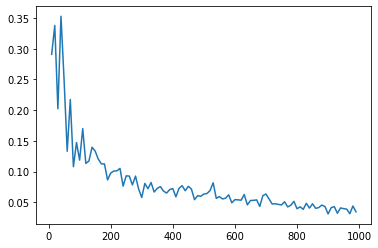

In [168]:
m_range = np.arange(10, 1000, 10)
error_distribution = []
for i in m_range:  
  dt = DecisionTree(k=10, m= i)
  dt.train()
  error_distribution.append(dt.estimate_distribution_error(N=100))
plt.plot(m_range, error_distribution)

In [164]:
dt.estimate_distribution_error(N=1000)

0.04258571428571416

***

6) Design an alternative metric for splitting the data, not based on information content / information gain. Repeat
the computation from (5) above for your metric, and compare the performance of your trees vs the ID3 trees.

The alternative approach for splitting that is implemented is GINI index, which measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen

Gini for each column is given by:

$ Gini = 1 - \sum_{i=1}^{n} (p_i)^2 $

$p_i$: probability of column values being 0 or 1 (In this case)


Steps:

1) Find Gini Index for all columns using the formula above 

2) Choose the column with smallest gini index as the splitting variable

3) Repeat the above two steps untill stopping condition

The implementation is as below:



```

def gini_fit(self, data):
    if (((data[:,-1]==0).sum(0) == len(data[:,-1])) or ((data[:,-1]==1).sum(0) == len(data[:,-1])) ):
      return Node("Y=0") if (data[:,-1] == 0).sum(0) == len(data[:,-1]) else Node("Y=1")
    gini = []
    for c in range(data.shape[1] - 1):
      N = len(data[:,c])
      c_0 = data[np.where(data[:,c] == 0)]
      c_1 = data[np.where(data[:,c] == 1)]
      G_c_0 = 1 - ((len(c_0[np.where(c_0[:,-1] == 0)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0) - ((len(c_0[np.where(c_0[:,-1] == 1)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0)
      G_c_1 = 1 - ((len(c_1[np.where(c_1[:,-1] == 0)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0) - ((len(c_1[np.where(c_1[:,-1] == 1)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0)
      gini.append(c_0.shape[0] / N * G_c_0 + c_1.shape[0] / N * G_c_1)
    gini = np.array(gini)
    split_var = gini.argmin()
    node = Node(split_var)
    node.left = self.gini_fit(data[np.where(data[:,split_var] == 0)])
    node.right = self.gini_fit(data[np.where(data[:,split_var] == 1)])
    return node

```



To train, we need to call the train method as below:


```
df.train("gini")
```




In [171]:
dt = DecisionTree(k=4, m=30)
dt.train("gini")


In [172]:
dt.tree.pretty_print()

    ┌Y=1
  ┌0┤
  | | ┌Y=0
  | └1┤
  |   | ┌Y=0
  |   └2┤
  |     └Y=1
 3┤
  |   ┌Y=1
  | ┌2┤
  | | └Y=0
  └0┤
    └Y=1


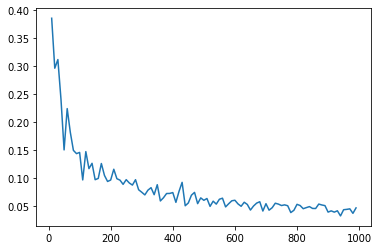

In [174]:
m_range = np.arange(10, 1000, 10)
error_distribution_gini = []
for i in m_range:  
  dt = DecisionTree(k=10, m= i)
  dt.train("gini")
  error_distribution_gini.append(dt.estimate_distribution_error(N=100))
plt.plot(m_range, error_distribution_gini)

Comparing both:

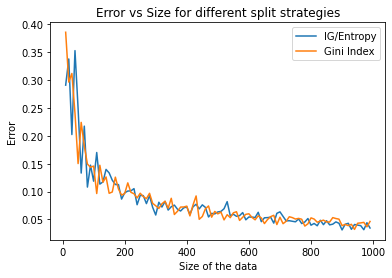

In [176]:
plt.plot(m_range,error_distribution, label="IG/Entropy")
plt.plot(m_range,error_distribution_gini, label="Gini Index")
plt.legend()
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.title("Error vs Size for different split strategies")
plt.show()